In [1]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

## Getting the data

Before you run this, make sure that you have generated a sliding_windows file by running 01_sliding_windows.

In [3]:
data_path = '../data/'

In [108]:
final_sliding_windows = pd.read_csv(data_path + '/sliding_windows_Thingy_smallest20_size20_step20.csv')

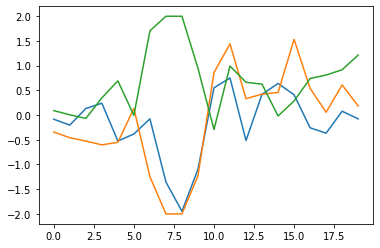

In [5]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
plot_by_id(final_sliding_windows, 'Respeck_s1865457_Falling on the back_30-09-2021_11-53-32')

## Split into training and test sets

Make sure to split by subject!

Take care if you have overlapping windows - this will need changing. 

In [109]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [110]:
# Simple for now
subjects = final_sliding_windows['subject_id'].unique()

train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]

X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]


## Format the input

Format data into windows - make (50,6) inputs

In [111]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [112]:
# Keep only the classes of interest
X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

# Create the y ones
y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values

y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)

In [113]:
X_train = []
X_test = []
    
for window_id, group in X_train_full.groupby('window_id'):
    #print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    #print(f"shape = {shape}")
    if shape == (20,6):
        X_train.append(group[columns_of_interest].values)
    
for window_id, group in X_test_full.groupby('window_id'):
    #print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    #print(f"shape = {shape}")
    
    X_test.append(group[columns_of_interest].values)
    
X_train = np.asarray(X_train)#, dtype=object)
X_test = np.asarray(X_test)#, dtype=object)

In [114]:
print(np.shape(X_train))
print(np.shape(X_test))

print(np.shape(y_train))
print(np.shape(y_test))

(22920, 20, 6)
(5868, 20, 6)
(22920, 18)
(5868, 18)


## Prepping the model

In [115]:
filters = 64
kernel_size = 3
n_features = 6
activation ='relu'
n_classes = len(class_labels)
window_size = 20
#filters = [3, 7, 11]

In [116]:
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 18, 64)            1216      
_________________________________________________________________
batch_normalization_16 (Batc (None, 18, 64)            256       
_________________________________________________________________
activation_15 (Activation)   (None, 18, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 64)            256       
_________________________________________________________________
activation_16 (Activation)   (None, 16, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 14, 64)           

## Training the model

In [117]:
model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])

In [118]:
model.fit(X_train, y_train, batch_size=100, epochs=10)

Train on 22920 samples
Epoch 1/10
22920/22920 [==============================] - 5s 221us/sample - loss: 1.7157 - accuracy: 0.3939
Epoch 2/10
22920/22920 [==============================] - 4s 153us/sample - loss: 1.2093 - accuracy: 0.5704
Epoch 3/10
22920/22920 [==============================] - 3s 148us/sample - loss: 1.0640 - accuracy: 0.6146
Epoch 4/10
22920/22920 [==============================] - 3s 144us/sample - loss: 0.9720 - accuracy: 0.6417
Epoch 5/10
22920/22920 [==============================] - 3s 146us/sample - loss: 0.9018 - accuracy: 0.6632
Epoch 6/10
22920/22920 [==============================] - 3s 146us/sample - loss: 0.8549 - accuracy: 0.6781
Epoch 7/10
22920/22920 [==============================] - 3s 150us/sample - loss: 0.8188 - accuracy: 0.6904 - loss: - ETA
Epoch 8/10
22920/22920 [==============================] - 4s 156us/sample - loss: 0.7907 - accuracy: 0.7029 - loss: 0.869
Epoch 9/10
22920/22920 [==============================] - ETA: 0s - loss: 0.7511 - ac

## Testing the model

In [119]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [120]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.24      0.11      0.15       337
           1       0.50      0.33      0.40       335
           2       0.17      0.22      0.19       336
           3       0.81      1.00      0.89       338
           4       0.81      0.48      0.60       333
           5       0.74      1.00      0.85       334
           6       1.00      0.89      0.94       337
           7       0.28      0.44      0.34       334
           8       0.69      0.80      0.74       372
           9       0.98      0.83      0.90       368
          10       0.75      0.89      0.82       373
          11       0.67      0.78      0.72       372
          12       0.27      0.30      0.29       337
          13       0.54      0.52      0.53       337
     

In [121]:
confusion_matrix = tf.math.confusion_matrix(
    y_true_labels, y_pred_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<AxesSubplot:>

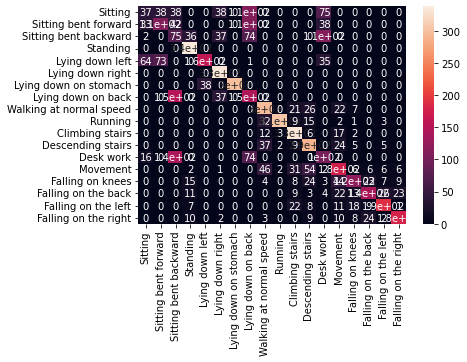

In [122]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())

### Save a test intance

In [107]:
for i in range(5):
    print(y_test[i])
    #np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [106]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Save to file and convert to tflite

In [123]:
# Saving the model to file
model_name = 'cnn_simple_full_thingy'

export_dir = 'models\\' + model_name
tf.saved_model.save(model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: models\cnn_simple_full_thingy\assets


473324